<a href="https://colab.research.google.com/github/YawBoah/MSCAssignments/blob/main/workforce_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
workforce = pd.read_csv('/content/Workforce_Data.csv')
forecast = pd.read_csv('/content/urban_grocers_forecast.csv')

In [6]:
workforce.head()

,Date,Store_ID,Staff_ID,Shift_Type,Hours_Worked,Staff_Role,Daily_Sales_Target,Staff_Attendance
0,2022-01-01,S001,E0167,Morning,8,Customer Service,1757.33,Present
1,2022-01-01,S001,E0110,Night,7,Manager,964.85,Present
2,2022-01-01,S001,E0107,Morning,8,Customer Service,2758.39,Present
3,2022-01-01,S001,E0132,Afternoon,6,Stock Clerk,4455.25,Present
4,2022-01-01,S001,E0092,Afternoon,4,Manager,848.00,Present


In [4]:
print(workforce.columns)

Index(['Date', 'Store_ID', 'Staff_ID', 'Shift_Type', 'Hours_Worked',
       'Staff_Role', 'Daily_Sales_Target', 'Staff_Attendance'],
      dtype='object')


In [7]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
workforce['Date'] = pd.to_datetime(workforce['Date'])

In [12]:

def attendance_to_numeric(value):
    return 1 if value.strip().lower() == 'present' else 0


workforce['attendance_numeric'] = workforce['Staff_Attendance'].apply(attendance_to_numeric)


daily_attendance = workforce.groupby('Date').agg({
    'attendance_numeric': 'sum',
    'Hours_Worked': 'sum',
    'Daily_Sales_Target': 'mean'
}).reset_index()

daily_attendance.rename(columns={
    'Date': 'ds',
    'attendance_numeric': 'Staff_Attendance'
}, inplace=True)


In [13]:
X = daily_attendance[['Daily_Sales_Target']]
y = daily_attendance['Staff_Attendance']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:
# Rename yhat to Daily_Sales_Target to match training
forecast = forecast.rename(columns={'yhat': 'Daily_Sales_Target'})

# Predict staffing using the trained model
forecast['predicted_staff'] = model.predict(forecast[['Daily_Sales_Target']])

# Round and set minimum 1 staff
forecast['predicted_staff'] = forecast['predicted_staff'].apply(lambda x: max(1, round(x)))


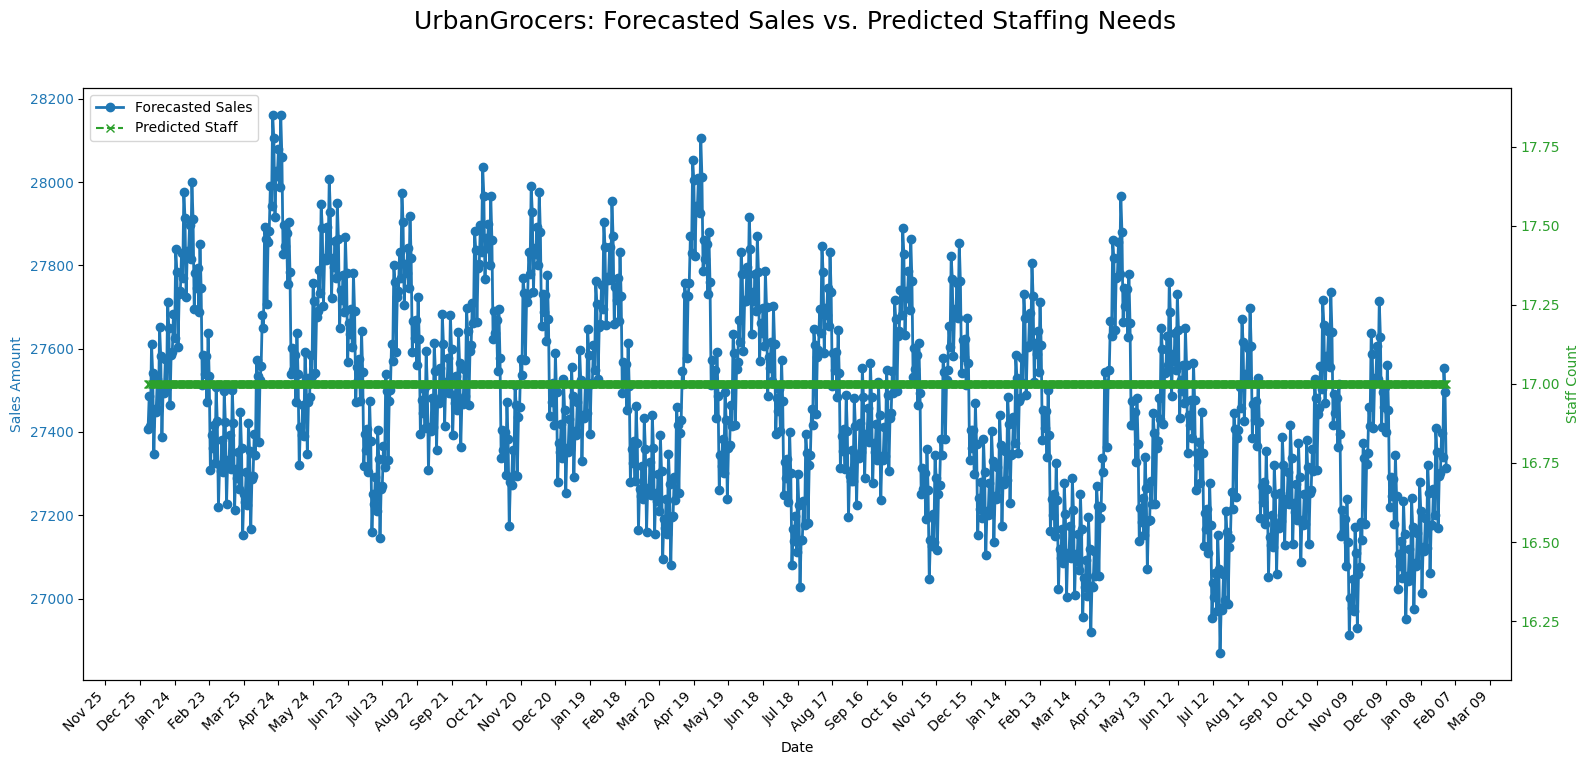

In [32]:
import matplotlib.dates as mdates

# Create a plot with larger figure size
fig, ax1 = plt.subplots(figsize=(16, 8))  # Increased the size to make space for better readability

# Plot Forecasted Sales (yhat) on the primary y-axis
ax1.plot(forecast['ds'], forecast['Daily_Sales_Target'], color='tab:blue', label='Forecasted Sales', linewidth=2, marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales Amount', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Format the x-axis with proper date formatting
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Show every 30th day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format dates as "Jan 01"
plt.xticks(rotation=45, ha='right')  # Rotate date labels by 45 degrees for clarity

# Plot Predicted Staff on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(forecast['ds'], forecast['predicted_staff'], color='tab:green', label='Predicted Staff', linestyle='--', marker='x')
ax2.set_ylabel('Staff Count', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Set title and layout adjustments
fig.suptitle('UrbanGrocers: Forecasted Sales vs. Predicted Staffing Needs', fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit everything

# Show combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


In [34]:
forecast[['ds', 'Daily_Sales_Target', 'predicted_staff']].to_csv('staffing_forecast.csv', index=False)
